# Figure 4: Equatorial thermocline depth 

1) Evalutate first cell to import necessary libraries und functions  
2) Scroll down to Plotting to load data for Figure 4 and plotting code

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import cmocean as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from scipy.interpolate import griddata
from scipy.io import loadmat
import datetime
import string

import sys
sys.path.append("./")  # adds upper level to working directory\n



# where to save plots
plotsave = 'plots/'
datapath = '/vortexfs1/share/clidex/data/'

In [2]:
################### load data ######################
zrange = slice(0,22)  #0m-734m for temp data
datapath2 = datapath+'publications/IOHC_Ummenhofer/'
k003 = xr.open_dataset(datapath2 + '/K003.hindcast_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k004 = xr.open_dataset(datapath2 + 'K004.thermhal90_temp_IndoPacific_30E_150W_70S_30N.nc',
                     chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k005 = xr.open_dataset(datapath2 + 'K005.wind90_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)

In [3]:
# derive mean section about equator

def sec_equ(ds,limits):
    ds_equ = ds.where((ds['nav_lat']>=limits[0]) & (ds['nav_lat']<=limits[1]),drop=True)
    ds_equ = ds_equ.where((ds_equ['nav_lon']<=101) & (ds_equ['nav_lon']>0),drop=True).load()
    lon_equ = ds_equ['nav_lon'][0,:]
    ds_equ = ds_equ.where(ds_equ['votemper']!=0)
    ds_equ= ds_equ.mean('y')
    return ds_equ,lon_equ

limits = [-5,5]  #average from 5S-5N
k003_equ,lon_equ = sec_equ(k003,limits)
k004_equ,_ = sec_equ(k004,limits)
k005_equ,_ = sec_equ(k005,limits)

In [ ]:
# find isosurface 

##################################################################
##################################################################
# helper functions

def calc_iso_surface(my_array, my_value, zs, interp_order=6, power_parameter=2):
    """
        - axis for interpolation, e.g. depth has to be first
        - should work for multidimensions as long as depth is first dimension
        - inputs have to be numpy arrays    
        
        ! Still not sure what power parameter does and I think weighting becomes almost
        unnecessary when data is interpolated in vertical first!
    """
    if interp_order < 1: interp_order = 1
    # derive squared difference
    dist = ((my_array - my_value)**2)
    # get index for sorted array in depth axis
    arg = np.argsort(dist,axis=0)
    # sort along depth
    dist.sort(axis=0)
    w_total = 0.
    # create output array
    z = np.zeros(my_array.shape[1:], dtype=float)
    for i in range(int(interp_order)):
        # depth index of value closest to target
        zi = np.take(zs, arg[i,::])
        # associated squared difference value
        valuei = dist[i,::]
        # weighting
        wi = 1/valuei
        np.clip(wi, 0, 1.e6, out=wi) # avoiding overflows
        w_total += wi**power_parameter
        z += zi*wi**power_parameter
    z /= w_total
    return z,dist[0,::]

def calc_thermocline(ds,val=20):
    # ds: dataset as xarray
    # val: value for isotherm
    from scipy.interpolate import griddata
    [x1,x2] = np.meshgrid(lon_equ,ds.deptht)
    [xm,ym] = np.meshgrid(lon_equ,np.arange(0,300))

    thermocline = np.empty((708,len(lon_equ.values)),dtype=float)
    for i in range(708):
        dummy = griddata((x1.ravel(),x2.ravel()),ds['votemper'][i,::].values.ravel(),(xm,ym))
        thermocline[i,:],_ = calc_iso_surface(dummy, my_value=val, zs=np.arange(0,300), interp_order=6)
    return thermocline

##################################################################
##################################################################


# apply functions above
thermocline_k003 = calc_thermocline(k003_equ,20)
thermocline_k004 = calc_thermocline(k004_equ,20)
thermocline_k005 = calc_thermocline(k005_equ,20)

In [42]:
# derive annual mean
k003_equ['thermocline'] = (('time_counter','lon'),thermocline_k003)
thermocline_am_k003 = k003_equ['thermocline'].groupby('time_counter.year').mean('time_counter')
thermocline_am_k003['lon'] = lon_equ['nav_lon'].values
k004_equ['thermocline'] = (('time_counter','lon'),thermocline_k004)
thermocline_am_k004 = k004_equ['thermocline'].groupby('time_counter.year').mean('time_counter')
thermocline_am_k004['lon'] = lon_equ['nav_lon'].values
k005_equ['thermocline'] = (('time_counter','lon'),thermocline_k005)
thermocline_am_k005 = k005_equ['thermocline'].groupby('time_counter.year').mean('time_counter')
thermocline_am_k005['lon'] = lon_equ['nav_lon'].values

# save fields for plotting
thermocline_am_k003.to_netcdf('../data/Fig4_annual_thermocline_depth_k003.nc')
thermocline_am_k004.to_netcdf('../data/Fig4_annual_thermocline_depth_k004.nc')
thermocline_am_k005.to_netcdf('../data/Fig4_annual_thermocline_depth_k005.nc')

# Plotting

In [46]:
# load data for plotting

thermocline_am_k003 = xr.open_dataset('../data/Fig4_annual_thermocline_depth_k003.nc')
thermocline_am_k004 = xr.open_dataset('../data/Fig4_annual_thermocline_depth_k004.nc')
thermocline_am_k005 = xr.open_dataset('../data/Fig4_annual_thermocline_depth_k005.nc')

Text(0.5, 1.0, 'c) wind')

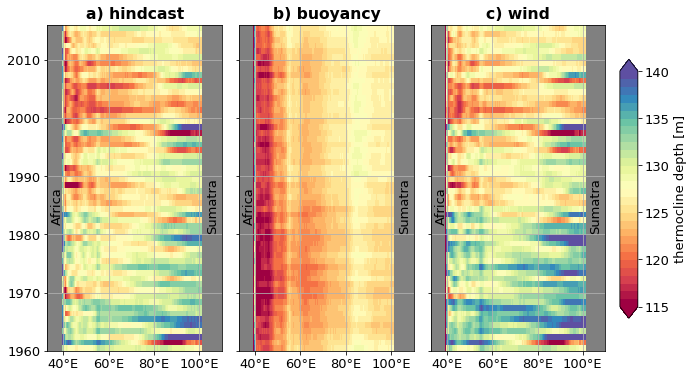

In [47]:
################# plot annual thermocline depth ########################

plt.rcParams.update({'font.size': 13})

fig,ax = plt.subplots(figsize=(10,6),ncols=3,sharey=True)
plt.subplots_adjust(wspace=0.1)

cc=ax[0].pcolormesh(thermocline_am_k003.lon,thermocline_am_k003.year,thermocline_am_k003.thermocline,vmin=115,vmax=140,
                    cmap=plt.get_cmap('Spectral',30))
ax[1].pcolormesh(thermocline_am_k004.lon,thermocline_am_k004.year,thermocline_am_k004.thermocline,vmin=115,vmax=140,cmap=plt.get_cmap('Spectral',30))
ax[2].pcolormesh(thermocline_am_k004.lon,thermocline_am_k005.year,thermocline_am_k005.thermocline,vmin=115,vmax=140,cmap=plt.get_cmap('Spectral',30))
ax[1].set_ylim(1960,2016)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.025, 0.6])
cb = fig.colorbar(cc,cax=cbar_ax,extend='both',shrink=0.7,label='thermocline depth [m]')

for i in range(3):
    ax[i].set_xlim(33,110) 
    ax[i].set_xticks(np.arange(40,120,20))
    ax[i].set_xticklabels(['40\N{DEGREE SIGN}E','60\N{DEGREE SIGN}E','80\N{DEGREE SIGN}E','100\N{DEGREE SIGN}E'])
    ax[i].grid()
    ax[i].set_facecolor('gray')
    ax[i].text(34.5,1985,'Africa',rotation=90,verticalalignment='center')
    ax[i].text(103,1985,'Sumatra',rotation=90,verticalalignment='center')
#     plt.ylim('1960-01','2017-01')

    
ax[0].set_title('a) hindcast',fontweight='bold')
ax[1].set_title('b) buoyancy',fontweight='bold')
ax[2].set_title('c) wind',fontweight='bold')

# plt.savefig(plotsave + 'Fig4_thermocline_5S_5N_depth_1960_2016.png',dpi=300,bbox_inches='tight')